In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from allensdk.api.queries.brain_observatory_api import BrainObservatoryApi 
import allensdk.brain_observatory.receptive_field_analysis.visualization as rfvis
import allensdk.brain_observatory.receptive_field_analysis.receptive_field as rf
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from scipy import sparse
from scipy import signal
from scipy import ndimage
import scipy.optimize as opt
import pandas as pd

%matplotlib inline

We will start by analyzing the off responses of a single cell. Later we will characterize the signal to noise properties of the whole population of neurons captured in this experiment.

In [2]:
#Cell of interest is in this particular experiment ID
exp_id = 561312433

# Set up a local cache of the data
boc = BrainObservatoryCache(manifest_file='/home/omer/boc/manifest.json')

exps = boc.get_ophys_experiments(experiment_container_ids=[exp_id])

# Create dataframe containing information about all cells
cells = pd.DataFrame.from_records(boc.get_cell_specimens())

In [3]:
# Get cell ids from this experiment
cells_in_experiment = cells['experiment_container_id'] == exp_id
valid_cells = cells[cells_in_experiment]
all_specimen_ids = valid_cells['cell_specimen_id'].reset_index(drop=True)

In [4]:
epoch_name = 'locally_sparse_noise_4deg'

kernel_length_forward = 30
kernel_length_back = 6

# Download the data from the experiment that contained our cell of interest.
# This will take several minutes. If interrupted, you will need to delete
# the cache file and start again.
# Only the first session contains locally sparse stimuli
data_set = boc.get_ophys_experiment_data(exps[0]['id'])

def get_stim_tensor(data_set):
    stim_movie_frames = data_set.get_stimulus_template(epoch_name)

    number_of_stim_frames = stim_movie_frames.shape[0]
    number_of_pixels = stim_movie_frames.shape[1]*stim_movie_frames.shape[2]

    frame_starts = data_set.get_stimulus_table(epoch_name)['start'].values
    num_imaging_frames = len(data_set.get_dff_traces()[1][1,:])
    stim_movie = np.zeros([num_imaging_frames,number_of_pixels])
    stim_movie[frame_starts,:] = (stim_movie_frames < 127).reshape([number_of_stim_frames,number_of_pixels]).astype(float)

    return stim_movie.reshape([num_imaging_frames,stim_movie_frames.shape[1],stim_movie_frames.shape[2]])

def gen_toeplitz(data_set,kernel_length_forward,kernel_length_back):
    kernel_length_total = kernel_length_forward + kernel_length_back - 1

    stim_tensor = get_stim_tensor(data_set)
    number_of_pixels = stim_tensor.shape[1]*stim_tensor.shape[2]
    num_imaging_frames = stim_tensor.shape[0]
    
    stim_movie = stim_tensor.reshape([num_imaging_frames,number_of_pixels])
    full_toeplitz = np.zeros([number_of_pixels,num_imaging_frames,kernel_length_total])
    for pp in range(0,number_of_pixels):
        tp_mat_forward = linalg.toeplitz(stim_movie[:,pp],np.zeros([kernel_length_forward]))
        tp_mat_back =  linalg.toeplitz(stim_movie[::-1,pp],np.zeros([kernel_length_back]))[::-1,:0:-1]
        full_toeplitz[pp,:,:] = np.concatenate((tp_mat_back,tp_mat_forward),axis=1)
    
    return full_toeplitz

full_toeplitz = gen_toeplitz(data_set,kernel_length_forward,kernel_length_back)
kernel_length_total = kernel_length_forward + kernel_length_back - 1

stim_movie_frames = data_set.get_stimulus_template(epoch_name)
number_of_stim_frames = stim_movie_frames.shape[0]
number_of_pixels = stim_movie_frames.shape[1]*stim_movie_frames.shape[2]


# Number of z planes in the simulated volume acquisition
num_slices = 9

In [5]:
# First we'll extract a filter from our example cell without regularization
example_cell_index = 22
dffs = data_set.get_dff_traces()[1]
dffs = dffs - np.mean(dffs,axis=1).reshape([-1,1])
example_dff_full = dffs[example_cell_index,:]

number_of_imaging_frames = len(example_dff_full)

for sample_style in ('full','volume_sim'):
    if sample_style == 'full':
        sampled_points = np.arange(number_of_imaging_frames)
    else:
        sampled_points = np.arange(number_of_imaging_frames,step=num_slices)
    
    example_kernel = np.zeros([number_of_pixels,kernel_length_total])
    for pp in range(0,number_of_pixels):
        example_kernel[pp,:] = np.linalg.lstsq(full_toeplitz[pp,sampled_points,:],example_dff_full[sampled_points])[0]
    
    if sample_style == 'full':
        full_kernel_matrix = example_kernel
    else:
        volume_kernel_matrix = example_kernel

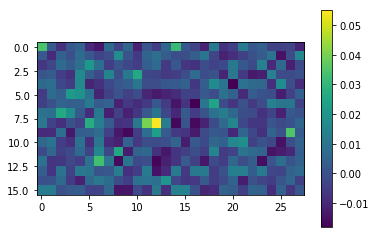

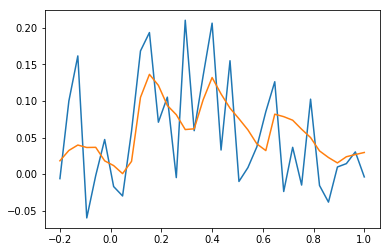

In [6]:
# Now plot the receptive field and temporal filter
receptive_field = np.mean(volume_kernel_matrix,1).reshape(stim_movie_frames.shape[1],stim_movie_frames.shape[2])
plt.figure()
plt.imshow(receptive_field)
plt.colorbar()

top_pixel = np.argsort(-np.sum(volume_kernel_matrix,1))[:1]

plt.figure()
plt.plot(np.linspace(-0.2,1,kernel_length_total),volume_kernel_matrix[top_pixel,:].transpose())
plt.plot(np.linspace(-0.2,1,kernel_length_total),full_kernel_matrix[top_pixel,:].transpose())

stim_tensor = get_stim_tensor(data_set)
stim_movie = stim_tensor.reshape([stim_tensor.shape[0],stim_tensor.shape[1]*stim_tensor.shape[2]])

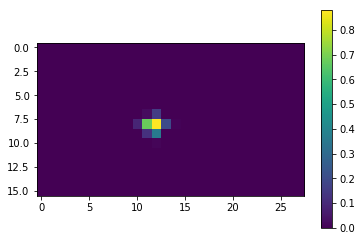

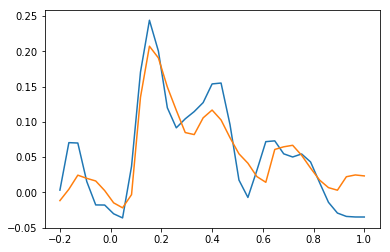

In [7]:
# Fit a guassian spatial receptive field and use it to find a temporal filter
def gauss2d((x, y), amp, x0, y0, a, b, c, offset):
    inner = a * (x - x0)**2
    inner += 2 * b * (x - x0)**2 * (y - y0)**2
    inner += c * (y - y0)**2
    return amp * np.exp(-inner).ravel() + offset

xv = np.linspace(0,1,stim_movie_frames.shape[2])
yv = np.linspace(0,1,stim_movie_frames.shape[1])
xm, ym = np.meshgrid(xv,yv)

for sample_style in ('full','volume_sim'):
    if sample_style == 'full':
        sampled_points = np.arange(number_of_imaging_frames)
    else:
        sampled_points = np.arange(number_of_imaging_frames,step=num_slices)
        
    kernel_matrix = np.zeros([number_of_pixels,kernel_length_total])
    for pp in range(0,number_of_pixels):
        kernel_matrix[pp,:] = np.linalg.lstsq(full_toeplitz[pp,sampled_points,:],example_dff_full[sampled_points])[0]

    receptive_field = np.mean(kernel_matrix,1).reshape(stim_movie_frames.shape[1],stim_movie_frames.shape[2])

    filtered_receptive_field = ndimage.gaussian_filter(receptive_field,1,mode='constant')
    mean_a = np.mean(filtered_receptive_field)
    max_idx = np.argmax(filtered_receptive_field.ravel())
    max_x = xm.ravel()[max_idx]
    max_y = ym.ravel()[max_idx]
    max_a = filtered_receptive_field.ravel()[max_idx]-mean_a
    guess = (max_a,max_x,max_y,100.0,1.0,100.0,mean_a)
    try:
        fit_params = opt.curve_fit(gauss2d,(xm,ym),receptive_field.ravel(),p0=guess)[0]
    except:
        print "Couldn't find best fit. Reverting to initial guess"
        fit_params = guess

    #rescale and ignore offset
    fit_params_mod = (1,fit_params[1],fit_params[2],fit_params[3],fit_params[4],fit_params[5],0)

    fit_receptive_field = gauss2d((xm,ym),*fit_params_mod)
    fit_toeplitz = np.zeros([len(sampled_points),kernel_length_total])
    for pp in range(0,number_of_pixels):
        fit_toeplitz += fit_receptive_field[pp]*full_toeplitz[pp,sampled_points,:]
    
    fit_temporal = np.linalg.lstsq(fit_toeplitz,example_dff_full[sampled_points])[0]
    if sample_style == 'full':
        full_regularized = fit_temporal
    else:
        volume_regularized = fit_temporal

#Plot the fit receptive field from volume simulation
plt.figure()
plt.imshow(fit_receptive_field.reshape(stim_movie_frames.shape[1],stim_movie_frames.shape[2]))
plt.colorbar()

#Low pass the resulting filter
b, a = signal.butter(8,0.5)
volume_regularized_filtered = signal.filtfilt(b, a, volume_regularized.reshape([-1,1]),padlen=0,axis=0)

plt.figure()
plt.plot(np.linspace(-0.2,1,kernel_length_total),volume_regularized_filtered)
plt.plot(np.linspace(-0.2,1,kernel_length_total),full_regularized.reshape([-1,1]))

In [8]:
# Now we'll extract regularized filters for all good cells in the Allen dataset
# we'll be comparing sparse and dense sampling for simulated volume acquisitions.

# This will take a while, especially the first time when we have to download the datasets. 
  
import allensdk.brain_observatory.stimulus_info as stim_info
all_exps = boc.get_ophys_experiments(stimuli=[stim_info.LOCALLY_SPARSE_NOISE_4DEG],targeted_structures=['VISp'])

# We don't yet know how many cells we'll be analyzing, so we initialize an empty
# array with num_cells=0. We'll later append results to this array as we proccess
# each experiment
output_kernels = np.zeros([0,num_slices+1,kernel_length_total])
output_kernels_one_pixel = np.zeros([0,num_slices+1,kernel_length_total])

for exp_idx in range(0,len(all_exps)):
    data_set = boc.get_ophys_experiment_data(all_exps[exp_idx]['id'])
    full_toeplitz = gen_toeplitz(data_set,kernel_length_forward,kernel_length_back)
    dffs = data_set.get_dff_traces()[1]
    dffs = dffs - np.mean(dffs,axis=1).reshape([-1,1])
    
    num_cells = dffs.shape[0]
    num_imaging_frames = dffs.shape[1]
    
    # Find good cells to analyze
    stim_movie_tensor = get_stim_tensor(data_set)
    stim_movie_tensor = stim_movie_tensor - np.mean(stim_movie_tensor,axis=0)
    
    def moving_average(a, n, axis) :
        ret = np.cumsum(a, dtype=float, axis=axis)
        ret[n:,:,:] = ret[n:,:,:] - ret[:-n,:,:]
        return ret / n
    
    time_averaged_stim = moving_average(stim_movie_tensor,n=30,axis=0)
    blurred_time_averaged_stim = ndimage.gaussian_filter(time_averaged_stim,(0,1,1),mode='constant')
    blurred_receptive_fields = np.matmul(dffs,blurred_time_averaged_stim.reshape([num_imaging_frames,stim_movie_frames.shape[1]*stim_movie_frames.shape[2]]))
    
    receptive_field_power = np.sqrt(np.mean(np.power(blurred_receptive_fields,2),axis=1))
    dff_stds = np.std(dffs,axis=1)
    receptive_field_normalized = blurred_receptive_fields / receptive_field_power.reshape([-1,1])
    receptive_field_max = np.max(receptive_field_normalized,axis=1)
    
    good_cell_idxs = np.nonzero(receptive_field_max>4.7)[0]
    
    output_kernels_this_exp = np.zeros([good_cell_idxs.size,num_slices+1,kernel_length_total])
    output_kernels_one_pixel_this_exp = np.zeros([good_cell_idxs.size,num_slices+1,kernel_length_total])
    for cell_num in range(0,len(good_cell_idxs)):
        cell_idx = good_cell_idxs[cell_num]        
        for slice_num in range(0,num_slices+1):
            dff_full = dffs[cell_idx,:]

            # last element in the slice dimension will represent extracting
            # from the full experiment
            if slice_num == num_slices:
                sampled_points = np.arange(num_imaging_frames)
            else:
                sampled_points = np.arange(slice_num,num_imaging_frames,num_slices)
            
            kernel_matrix = np.zeros([number_of_pixels,kernel_length_total])
            for pp in range(0,number_of_pixels):
                # least squares fitting to pixels independently can cause some problems. Use reverse correlation instead
                kernel_matrix[pp,:] = np.matmul(dff_full[sampled_points].transpose(),
                                          full_toeplitz[pp,sampled_points,:].reshape((len(sampled_points),kernel_length_total)))

            receptive_field = np.mean(kernel_matrix,1).reshape(stim_movie_frames.shape[1],stim_movie_frames.shape[2])

            filtered_receptive_field = ndimage.gaussian_filter(receptive_field,1,mode='constant')
            mean_a = np.mean(filtered_receptive_field)
            max_idx = np.argmax(filtered_receptive_field.ravel())
            max_x = xm.ravel()[max_idx]
            max_y = ym.ravel()[max_idx]
            max_a = filtered_receptive_field.ravel()[max_idx]-mean_a
            guess = (max_a,max_x,max_y,100.0,1.0,100.0,mean_a)
            try:
                fit_params = opt.curve_fit(gauss2d,(xm,ym),receptive_field.ravel(),p0=guess)[0]
            except:
                print "Couldn't find best fit. Reverting to initial guess"
                fit_params = guess

            #rescale and ignore offset
            fit_params_mod = (1,fit_params[1],fit_params[2],fit_params[3],fit_params[4],fit_params[5],0)

            fit_receptive_field = gauss2d((xm,ym),*fit_params_mod)
            fit_toeplitz = np.zeros([len(sampled_points),kernel_length_total])
            for pp in range(0,number_of_pixels):
                fit_toeplitz += fit_receptive_field[pp]*full_toeplitz[pp,sampled_points,:]
            fit_temporal = np.linalg.lstsq(fit_toeplitz,dff_full[sampled_points])[0]
            output_kernels_this_exp[cell_num,slice_num,:] = fit_temporal
            output_kernels_one_pixel_this_exp[cell_num,slice_num,:] = kernel_matrix[max_idx,:]

    #Now concatonate the results from this experiment with all the others
    output_kernels = np.concatenate((output_kernels,output_kernels_this_exp),axis=0)
    output_kernels_one_pixel = np.concatenate((output_kernels_one_pixel,output_kernels_one_pixel_this_exp),axis=0)

/home/omer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess


/home/omer/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverting to initial guess
Couldn't find best fit. Reverti

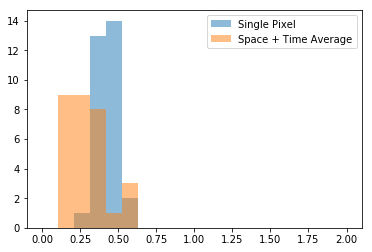

In [9]:
# Find error for each sample and then generate histograms of errors in sparse and dense sampling
num_cells = output_kernels.shape[0]
deviations = np.zeros([2,num_cells,num_slices,kernel_length_total])
deviations[0,:,:,:] = (output_kernels_one_pixel[:,0:num_slices,:]
                      -output_kernels_one_pixel[:,num_slices,:].reshape([num_cells,1,kernel_length_total]))
deviations[1,:,:,:] = (signal.filtfilt(b,a,output_kernels[:,0:num_slices,:])
                      -output_kernels[:,num_slices,:].reshape([num_cells,1,kernel_length_total]))

single_pixel_true_max = np.max(output_kernels_one_pixel[:,num_slices,:],axis=1).reshape([1,num_cells,1])
regularized_true_max = np.max(output_kernels[:,num_slices,:],axis=1).reshape([1,num_cells,1])
full_kernel_max = np.concatenate((single_pixel_true_max,regularized_true_max),axis=0)

scaled_error_power = np.sqrt(np.mean(np.power(deviations,2),axis=3)).reshape([2,num_cells,num_slices]) / full_kernel_max
med_scaled_error_power = np.median(scaled_error_power,axis=2)

plt.figure()
plt.hist(med_scaled_error_power[0,:].ravel(),bins=np.linspace(0,2,20),alpha=0.5)
plt.hist(med_scaled_error_power[1,:].ravel(),bins=np.linspace(0,2,20),alpha=0.5)
plt.legend(['Single Pixel','Space + Time Average'])